In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
import json
import os
import glob
from geopy.geocoders import Nominatim
import re
import pandas as pd
from torchvision.io import read_image
from sklearn.preprocessing import LabelEncoder
from torch.utils.tensorboard import SummaryWriter
import sklearn
from torchvision.transforms import InterpolationMode
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
import math
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True 

In [2]:
from pathlib import Path
import argparse
import json
import os
import random
import signal
import sys
import time
import urllib

from torch import nn, optim
from torchvision import datasets, transforms
import torch
torch.cuda.empty_cache()

import resnet

import numpy as np
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
import json

import glob
from geopy.geocoders import Nominatim
import re
import pandas as pd
from torchvision.io import read_image
from sklearn.preprocessing import LabelEncoder
from torch.utils.tensorboard import SummaryWriter
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
import math
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True   #OTHERWISE TRUNCATED IMAGE FILE ERROR SOMEWHERE IN ENUMERATE(DATALOADER)!!!!

import resnet

import torchvision

from munkres import Munkres

In [3]:
def get_y_preds(cluster_assignments, y_true, n_clusters):
    '''
    Computes the predicted labels, where label assignments now
    correspond to the actual labels in y_true (as estimated by Munkres)

    cluster_assignments:    array of labels, outputted by kmeans
    y_true:                 true labels
    n_clusters:             number of clusters in the dataset

    returns:    a tuple containing the accuracy and confusion matrix,
                in that order
    '''
    confusion_matrix = sklearn.metrics.confusion_matrix(y_true, cluster_assignments, labels=None)
    # compute accuracy based on optimal 1:1 assignment of clusters to labels
    cost_matrix = calculate_cost_matrix(confusion_matrix, n_clusters)
    indices = Munkres().compute(cost_matrix)
    kmeans_to_true_cluster_labels = get_cluster_labels_from_indices(indices)
    y_pred = kmeans_to_true_cluster_labels[cluster_assignments]
    return y_pred, confusion_matrix 

def calculate_cost_matrix(C, n_clusters):
    cost_matrix = np.zeros((n_clusters, n_clusters))

    # cost_matrix[i,j] will be the cost of assigning cluster i to label j
    for j in range(n_clusters):
        s = np.sum(C[:,j]) # number of examples in cluster i
        for i in range(n_clusters):
            t = C[i,j]
            cost_matrix[j,i] = s-t
    return cost_matrix

def get_cluster_labels_from_indices(indices):
    n_clusters = len(indices)
    clusterLabels = np.zeros(n_clusters)
    for i in range(n_clusters):
        clusterLabels[i] = indices[i][1]
    return clusterLabels

In [4]:
batch_size = 1

In [5]:
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transforms = torchvision.transforms.Compose([torchvision.transforms.RandomResizedCrop(224), torchvision.transforms.RandomHorizontalFlip(), torchvision.transforms.ToTensor(),normalize])

dataset = datasets.ImageFolder('./ImageNet/ILSVRC/Data/CLS-LOC/val' , transforms)

dataloader = DataLoader(dataset=dataset, batch_size = batch_size, shuffle = False)


In [6]:
torch.cuda.current_device()
torch.cuda.set_device(3)
print(torch.cuda.mem_get_info(torch.cuda.current_device()))
device = torch.cuda.current_device()

(12268863488, 12806062080)


In [7]:
supervised_model_pretrained = torchvision.models.resnet50(pretrained=True)
torch.save(supervised_model_pretrained.state_dict(), 'resnet50_imagenet_pretrained_supervised.pth')

In [8]:
backbone, embedding = resnet.__dict__['resnet50'](zero_init_residual=True)
state_dict = torch.load('resnet50_imagenet_pretrained_supervised.pth', map_location="cpu")
if "model" in state_dict:
    state_dict = state_dict["model"]
    state_dict = {key.replace("module.backbone.", ""): value for (key, value) in state_dict.items()}
backbone.load_state_dict(state_dict, strict=False)
backbone.to(device)

ResNet(
  (padding): ConstantPad2d(padding=(1, 1, 1, 1), value=0.0)
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(2, 2), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(


In [9]:
print(embedding)
backbone.eval()

2048


ResNet(
  (padding): ConstantPad2d(padding=(1, 1, 1, 1), value=0.0)
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(2, 2), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(


In [10]:
labels_list = []
embeddings_list = []

labels_unseen_list = []
embeddings_unseen_list = []

with torch.no_grad():
    
    for i, (inputs, labels) in enumerate(dataloader):
        
        if i == 50000:
            break
            
        if i%500 == 0:
            print(i)
            
        if i%4 == 0:
            
            embedding = backbone(inputs.to(device))
            embeddings_unseen_list.append(embedding)
            labels_unseen_list.append(labels)
            
        else:
            
            embedding = backbone(inputs.to(device))
            embeddings_list.append(embedding)
            labels_list.append(labels)
            

    


0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
29500
30000
30500
31000
31500
32000
32500
33000
33500
34000
34500
35000
35500
36000
36500
37000
37500
38000
38500
39000
39500
40000
40500
41000
41500
42000
42500
43000
43500
44000
44500
45000
45500
46000
46500
47000
47500
48000
48500
49000
49500


In [11]:
embeddings_seen_arr = np.zeros((int(3*len(dataloader)/4), 2048))
counter = 0
for embedding in embeddings_list:
    embeddings_seen_arr[counter,:] = embedding.cpu().detach().numpy()
    counter += 1

print(embeddings_seen_arr)
labels_seen_arr = np.zeros(int(3*len(dataloader)/4))
counter = 0
for i in labels_list:
    labels_seen_arr[counter] = i.detach().numpy()
    counter += 1
print(np.unique(labels_seen_arr))

embeddings_unseen_arr = np.zeros((int(len(dataloader)/4), 2048))
counter = 0
for embedding in embeddings_unseen_list:
    embeddings_unseen_arr[counter,:] = embedding.cpu().detach().numpy()
    counter += 1

print(embeddings_unseen_arr)
labels_unseen_arr = np.zeros(int(len(dataloader)/4))
counter = 0
for i in labels_unseen_list:
    labels_unseen_arr[counter] = i.detach().numpy()
    counter += 1
print(np.unique(labels_unseen_arr))

[[0.14875932 0.40740678 0.24900784 ... 0.42377618 0.62659913 0.26762429]
 [0.15100792 0.57644802 0.06908274 ... 0.32252085 1.0731976  0.4173148 ]
 [0.14548095 0.86708254 0.20886353 ... 0.20139341 1.05986702 0.19876178]
 ...
 [0.08778701 0.33687139 1.03078735 ... 0.24490468 0.23621872 0.15081446]
 [0.24522467 0.36625695 0.32675669 ... 0.25291982 0.05003487 0.1373997 ]
 [0.26443723 0.60494483 1.97403979 ... 0.34973338 0.31702667 0.34852833]]
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]


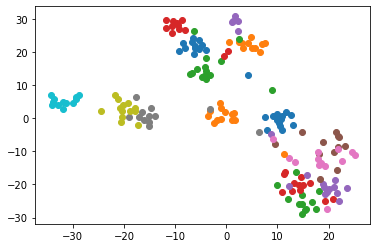

In [12]:
#JUST TRY DELETE LATER

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

embeddings_unseen_arr_trial = embeddings_unseen_arr[0:180,:]
labels_unseen_arr_trial = labels_unseen_arr[0:180]

#pca = PCA(n_components=2)
#pca.fit(embeddings_unseen_arr)
#print(pca.explained_variance_ratio_)

#embeddings_reduced = pca.transform(embeddings_unseen_arr)
#print(embeddings_reduced)

u_labels = np.unique(labels_unseen_arr_trial)
print(u_labels)

embeddings_reduced = TSNE(n_components=2, learning_rate='auto',init='random', perplexity = 10.0).fit_transform(embeddings_unseen_arr_trial)

for i in u_labels:
    
    plt.scatter(embeddings_reduced[labels_unseen_arr_trial == i , 0] , embeddings_reduced[labels_unseen_arr_trial == i , 1] , label = i)

#plt.legend()
plt.show()

In [13]:
from sklearn.neighbors import KNeighborsClassifier

n_neighbours = [1, 3, 5, 10, 20, 30, 40, 50]

for k in n_neighbours:
    
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(embeddings_seen_arr, labels_seen_arr)
    labels_predicted = knn.predict(embeddings_unseen_arr)

    #print('Accuracy' + str(k) + ':', np.sum(labels_unseen_arr == labels_predicted)/len(labels_unseen_arr))
    print('Accuracy:', knn.score(embeddings_unseen_arr, labels_unseen_arr))

Accuracy: 0.53104
Accuracy: 0.5348
Accuracy: 0.56032
Accuracy: 0.57928
Accuracy: 0.58632
Accuracy: 0.58416
Accuracy: 0.58
Accuracy: 0.57856


In [16]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=1000, random_state=0).fit(embeddings_seen_arr)
labels_predicted = kmeans.predict(embeddings_unseen_arr)
print(labels_predicted)

from sklearn import metrics

print(metrics.rand_score(labels_unseen_arr, labels_predicted))

truth = labels_unseen_arr
pred=labels_predicted
print(np.sum( get_y_preds(pred, truth, 1000)[0] == truth )/len(truth) )

[328 199 199 ... 239 239 123]
0.9985074901992159
0.474


In [17]:
vicreg_model_pretrained = torch.hub.load('facebookresearch/vicreg:main', 'resnet50')
torch.save(vicreg_model_pretrained.state_dict(), 'resnet50_imagenet_pretrained_vicreg.pth')

Using cache found in /local/home/bsoyuer/.cache/torch/hub/facebookresearch_vicreg_main


In [18]:
backbone, embedding = resnet.__dict__['resnet50'](zero_init_residual=True)
state_dict = torch.load('resnet50_imagenet_pretrained_vicreg.pth', map_location="cpu")
if "model" in state_dict:
    state_dict = state_dict["model"]
    state_dict = {key.replace("module.backbone.", ""): value for (key, value) in state_dict.items()}
backbone.load_state_dict(state_dict, strict=False)
backbone.to(device)

ResNet(
  (padding): ConstantPad2d(padding=(1, 1, 1, 1), value=0.0)
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(2, 2), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(


In [19]:
print(embedding)
backbone.eval()

2048


ResNet(
  (padding): ConstantPad2d(padding=(1, 1, 1, 1), value=0.0)
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(2, 2), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(


In [20]:
labels_list = []
embeddings_list = []

labels_unseen_list = []
embeddings_unseen_list = []

with torch.no_grad():
    
    for i, (inputs, labels) in enumerate(dataloader):
        
        #if i == 50000:
            #break
            
        if i%500 == 0:
            print(i)
            
        if i%4 == 0:
            embedding = backbone(inputs.to(device))
            embeddings_unseen_list.append(embedding)
            labels_unseen_list.append(labels)
            
        else:
            embedding = backbone(inputs.to(device))
            embeddings_list.append(embedding)
            labels_list.append(labels)
            

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
29500
30000
30500
31000
31500
32000
32500
33000
33500
34000
34500
35000
35500
36000
36500
37000
37500
38000
38500
39000
39500
40000
40500
41000
41500
42000
42500
43000
43500
44000
44500
45000
45500
46000
46500
47000
47500
48000
48500
49000
49500


In [21]:
embeddings_seen_arr = np.zeros((int(3*len(dataloader)/4), 2048))
counter = 0
for embedding in embeddings_list:
    embeddings_seen_arr[counter,:] = embedding.cpu().detach().numpy()
    counter += 1

print(embeddings_seen_arr)
labels_seen_arr = np.zeros(int(3*len(dataloader)/4))
counter = 0
for i in labels_list:
    labels_seen_arr[counter] = i.detach().numpy()
    counter += 1
print(np.unique(labels_seen_arr))

embeddings_unseen_arr = np.zeros((int(len(dataloader)/4), 2048))
counter = 0
for embedding in embeddings_unseen_list:
    embeddings_unseen_arr[counter,:] = embedding.cpu().detach().numpy()
    counter += 1

print(embeddings_unseen_arr)
labels_unseen_arr = np.zeros(int(len(dataloader)/4))
counter = 0
for i in labels_unseen_list:
    labels_unseen_arr[counter] = i.detach().numpy()
    counter += 1
print(np.unique(labels_unseen_arr))

[[0.1175919  0.178287   0.         ... 0.65092319 0.         0.01470529]
 [0.         0.01578594 0.         ... 0.         0.         0.13610066]
 [0.03547306 0.00303839 0.         ... 0.13677892 0.17592302 0.        ]
 ...
 [0.64179617 0.00686585 0.         ... 0.92202634 0.00403233 0.28097665]
 [0.38417003 0.         0.         ... 0.07829548 0.         2.59024048]
 [0.75951803 0.17255424 0.         ... 0.01579968 0.05882057 0.03095703]]
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109

In [22]:
from sklearn.neighbors import KNeighborsClassifier

n_neighbours = [1, 3, 5, 10, 20, 30, 40, 50]

for k in n_neighbours:
    
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(embeddings_seen_arr, labels_seen_arr)
    labels_predicted = knn.predict(embeddings_unseen_arr)

    #print('Accuracy' + str(k) + ':', np.sum(labels_unseen_arr == labels_predicted)/len(labels_unseen_arr))
    print('Accuracy:', knn.score(embeddings_unseen_arr, labels_unseen_arr))

Accuracy: 0.42552
Accuracy: 0.41096
Accuracy: 0.43504
Accuracy: 0.45112
Accuracy: 0.46
Accuracy: 0.45696
Accuracy: 0.4556
Accuracy: 0.45544


[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]


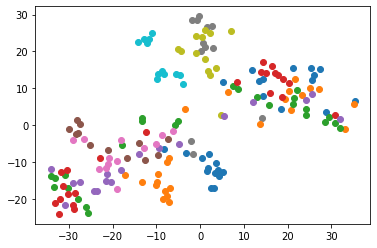

In [23]:
#JUST TRY DELETE LATER

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

embeddings_unseen_arr_trial = embeddings_unseen_arr[0:180,:]
labels_unseen_arr_trial = labels_unseen_arr[0:180]

#pca = PCA(n_components=2)
#pca.fit(embeddings_unseen_arr)
#print(pca.explained_variance_ratio_)

#embeddings_reduced = pca.transform(embeddings_unseen_arr)
#print(embeddings_reduced)

u_labels = np.unique(labels_unseen_arr_trial)
print(u_labels)

embeddings_reduced = TSNE(n_components=2, learning_rate='auto',init='random', perplexity = 10.0).fit_transform(embeddings_unseen_arr_trial)

for i in u_labels:
    
    plt.scatter(embeddings_reduced[labels_unseen_arr_trial == i , 0] , embeddings_reduced[labels_unseen_arr_trial == i , 1] , label = i)

#plt.legend()
plt.show()

In [24]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=1000, random_state=36).fit(embeddings_seen_arr)
labels_predicted = kmeans.predict(embeddings_unseen_arr)
print(labels_predicted)

from sklearn import metrics

print(metrics.rand_score(labels_unseen_arr, labels_predicted))

truth = labels_unseen_arr
pred=labels_predicted
print(np.sum( get_y_preds(pred, truth, 1000)[0] == truth )/len(truth) )

[244 381 381 ... 187 740 297]
0.9980117577406192
0.31992


In [25]:
print(embeddings_seen_arr.shape)
print(embeddings_unseen_arr.shape)

(37500, 2048)
(12500, 2048)
